# Bayesian Persuasion

A defendant is 30% likely to be guilty. The prosecutor is given the option to order a test, and gets to choose the test's precision and recall. The test's results must be reported to the judge. Is it possible for the prosecutor to sway the judge with such a test? Note that the judge knows the prosecutor ordered the test and chose its parameters.

Kamenica, E., & Gentzkow, M. (2011). Bayesian persuasion. American Economic Review, 101(6), 2590-2615.

In [1]:
from memo import memo, domain
import jax.numpy as np
import jax
from enum import IntEnum
from matplotlib import pyplot as plt

In [2]:
class State(IntEnum):
    Innocent = 0
    Guilty = 1

class Result(IntEnum):
    Exonerating = 0
    Incriminating = 1

class Verdict(IntEnum):
    Acquit = 0
    Convict = 1

Probability = np.linspace(1e-10, 1 - 1e-10, 50 + 1)
Test = domain(pi_i=len(Probability), pi_g=len(Probability))

def showd(z):
    z = z.reshape(len(Probability), len(Probability))
    img = plt.imshow(z, origin='lower')
    plt.colorbar(img)
    plt.xlabel('Test accuracy if guilty')
    plt.ylabel('Test accuracy if innocent')

@jax.jit
def run_test(r, s, t):
    p_i, p_g = Test._tuple(t)
    p_i = Probability[p_i]
    p_g = Probability[p_g]
    return np.array([
        [p_i, 1 - p_i],
        [1 - p_g, p_g]
    ])[s, r]

In [3]:
@memo
def prosecutor[t: Test](level):
    # prosecutor maximizes p(judge convicts)
    pros: chooses(t in Test, wpp=exp(10 * judge[t](level)))
    return Pr[pros.t == t]

@memo
def judge[t: Test](level):
    judge: thinks[
        defendant: chooses(s in State, wpp=0.7 if s == 0 else 0.3),
        prosecutor: chooses(t in Test, wpp=prosecutor[t](level - 1) if level > 0 else 1),
        defendant: knows(prosecutor.t),
        defendant: chooses(r in Result, wpp=run_test(r, s, prosecutor.t))
    ]

    defendant: chooses(s in State, wpp=0.7 if s == 0 else 0.3)
    defendant: knows(t)
    defendant: chooses(r in Result, wpp=run_test(r, s, t))

    judge: observes [prosecutor.t] is t
    judge: observes [defendant.r] is defendant.r
    judge: chooses(v in Verdict, to_maximize=Pr[v == defendant.s])
    return Pr[judge.v == 1]

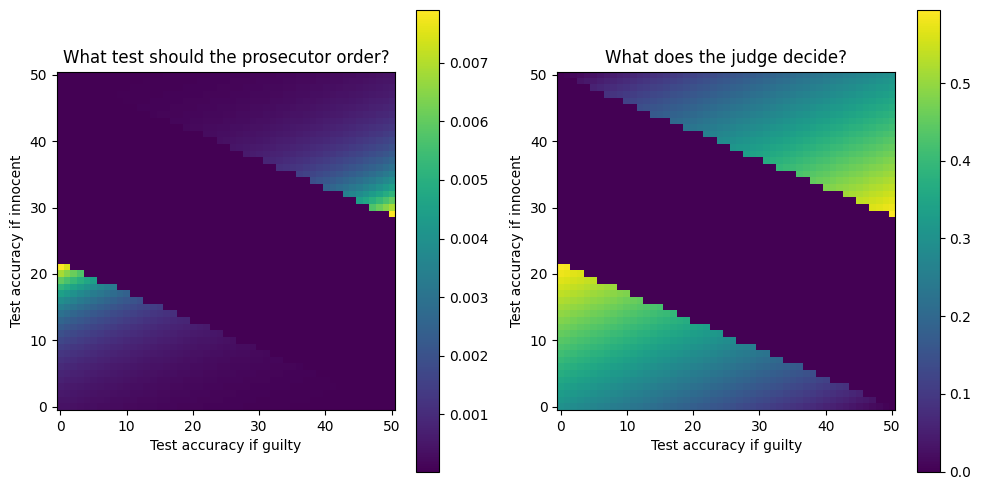

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
showd(prosecutor(1))
plt.title("What test should the prosecutor order?")
plt.subplot(1, 2, 2)
showd(judge(1))
plt.title("What does the judge decide?")
plt.tight_layout()

Interpreting the left chart: the prosecutor should pick a test that is perfectly accurate if the defendant is guilty, but only slightly better than chance if the defendant is innocent.

Interpreting the right chart: For uninformative tests (middle section) the judge never convicts, and for fully informative tests (top-right corner) the judge convicts 30% of the time. But, if faced with the prosecutor's optimal test, the judge convicts 60% of the time!